# NDP Songs Lyrics Analysis

> Published June. 2019 by Sujin Lee


### Background

This work aims to analyze official Singapore National Day Parade songs from 1984 to 2019. 
This analysis was used to support "Know your NDP songs?" interactive graphics work by The Strait Times.

https://graphics.straitstimes.com/STI/STIMEDIA/Interactives/2019/06/hit-or-miss-rank-your-ndp-songs/index.html



### Installation

Before staring work, download packages.

```shell
pip install numpy scipy matplotlib ipython scikit-learn pandas wordcloud nltk gensim bokeh
```

Then, download nltk stopwords package.

```shell
> python
$ import nltk
$ nltk.download(‘stopwords’)
```

In [118]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib
from matplotlib import pyplot as plt
import os

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


## Loading and inspecting data

In [119]:
data = pd.read_csv("./songs.csv")
data

,year,title,composer,writer,singer,lyrics
0,1984,Stand Up for Singapore,Hugh Harrison,Hugh Harrison,NaN,"Stand up for Singapore, do the best you can\nR..."
1,1986,"Count on Me, Singapore",Hugh Harrison,Hugh Harrison,Clement Chow,"We have a vision for tomorrow, just believe, j..."
2,1987,We are Singapore,Hugh Harrison,Hugh Harrison,"Jonathan Tan Teck Meng, Roslinda Baharudin, Ro...",There was a time when people said\nThat Singap...
3,1990,"One People, One Nation, One Singapore",Jeremy Monteiro,Jim Aitchison,NaN,We've built a nation with our hands\n The toil...
4,1998,Home,Dick Lee,Dick Lee,Kit Chan,Whenever I am feeling low\n I look around me a...
5,1999,Together,Ken Lim,Ken Lim,Evelyn Tan and Dreamz FM,Let us be together aspire to achieve\n No matt...
6,2000,Shine on Me,Jim Lim,Jim Lim,Mavis Hee and Jai Wahab,"The moment when I was born\n Into this world, ..."
7,2001,Where I Belong,Ken Lim,Ken Lim,Tanya Chua,Morning comes around and I\n Can't wait to see...
8,2002,We Will Get There,Dick Lee,Dick Lee,Stefanie Sun,"Remember the days, we set out together with fa..."
9,2003,One United People,Joshua Wan,Joshua Wan,Stefanie Sun,One Singapore\n One people strong and free\n W...


## Feature Engineering
#### Removing punctions & white spaces


In [120]:
def formatted_text(text):
    '''a function for removing punctuation & whitespace characters'''
    import string
    # replacing the punctuations with no space, 
    # which in effect deletes the punctuation marks 
    translator = str.maketrans('', '', string.punctuation)
    # return the text stripped of punctuation marks
    result = text.translate(translator)
    
    #result = result.replace("\n","")
    return result.lower()

In [121]:
data['lyrics'] = data['lyrics'].apply(formatted_text)
data['lyrics']

0     stand up for singapore do the best you can\nre...
1     we have a vision for tomorrow just believe jus...
2     there was a time when people said\nthat singap...
3     weve built a nation with our hands\n the toil ...
4     whenever i am feeling low\n i look around me a...
5     let us be together aspire to achieve\n no matt...
6     the moment when i was born\n into this world i...
7     morning comes around and i\n cant wait to see ...
8     remember the days we set out together with fai...
9     one singapore\n one people strong and free\n w...
10    whenever i am feeling low\n i look around me a...
11    at a time when hope was low\n the journey seem...
12    this is my home\n shes everything to me\n grac...
13    ive walked the streets of cairo and bombay\n i...
14    will you make this island\n amazing in all way...
15    have you seen a star\n one that guides you no ...
16    theres a jewel on the ocean\n a gem upon the s...
17    its a brand new day a brand new story\n i 

#### Apply the function to each examples


In [122]:
def length(text):    
    '''a function which returns the length of text'''
    return len(str(text))
data['length'] = data['lyrics'].apply(length)
data

,year,title,composer,writer,singer,lyrics,length
0,1984,Stand Up for Singapore,Hugh Harrison,Hugh Harrison,NaN,stand up for singapore do the best you can\nre...,608
1,1986,"Count on Me, Singapore",Hugh Harrison,Hugh Harrison,Clement Chow,we have a vision for tomorrow just believe jus...,846
2,1987,We are Singapore,Hugh Harrison,Hugh Harrison,"Jonathan Tan Teck Meng, Roslinda Baharudin, Ro...",there was a time when people said\nthat singap...,956
3,1990,"One People, One Nation, One Singapore",Jeremy Monteiro,Jim Aitchison,NaN,weve built a nation with our hands\n the toil ...,548
4,1998,Home,Dick Lee,Dick Lee,Kit Chan,whenever i am feeling low\n i look around me a...,795
5,1999,Together,Ken Lim,Ken Lim,Evelyn Tan and Dreamz FM,let us be together aspire to achieve\n no matt...,718
6,2000,Shine on Me,Jim Lim,Jim Lim,Mavis Hee and Jai Wahab,the moment when i was born\n into this world i...,738
7,2001,Where I Belong,Ken Lim,Ken Lim,Tanya Chua,morning comes around and i\n cant wait to see ...,936
8,2002,We Will Get There,Dick Lee,Dick Lee,Stefanie Sun,remember the days we set out together with fai...,1010
9,2003,One United People,Joshua Wan,Joshua Wan,Stefanie Sun,one singapore\n one people strong and free\n w...,1008


#### Histogram of text lenght of each song lyric


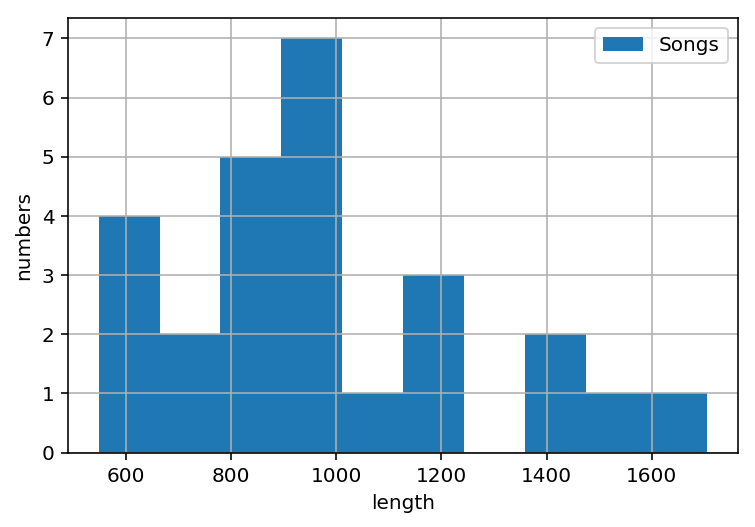

In [123]:
# matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
bins = 500

plt.hist(list(data['length']), alpha = 1, label='Songs')

plt.xlabel('length')
plt.ylabel('numbers')
plt.grid()


plt.legend(loc='upper right')

plt.show()

####  Removing Stopwords

In [124]:
# extracting the stopwords from nltk library
sw = stopwords.words('english')
# displaying the stopwords
np.array(sw)

print("Number of stopwords: ", len(sw))

Number of stopwords:  179


In [125]:
def stopwords(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)

data['lyrics'] = data['lyrics'].apply(stopwords)


## Stemming
#### Collect vocabulary count

In [126]:
# create a count vectorizer object
count_vectorizer = CountVectorizer()
# fit the count vectorizer using the text data
count_vectorizer.fit(data['lyrics'])
# collect the vocabulary items used in the vectorizer
dictionary = count_vectorizer.vocabulary_.items()  


In [127]:
# lists to store the vocab and counts
vocab = []
count = []
# iterate through each vocab and count append the value to designated lists
for key, value in dictionary:
    vocab.append(key)
    count.append(value)
# store the count in panadas dataframe with vocab as index
vocab_bef_stem = pd.Series(count, index=vocab)

# sort the dataframe
vocab_bef_stem = vocab_bef_stem.sort_values(ascending=False)


In [128]:
top_vacab = vocab_bef_stem.head(10)
top_vacab

youve       595
youre       594
young       593
youll       592
you         591
yo          590
yet         589
years       588
yearning    587
yeah        586
dtype: int64

In [129]:
# create an object of stemming function
stemmer = SnowballStemmer("english")

def stemming(text):    
    '''a function which stems each word in the given text'''
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text) 


In [130]:
data['lyrics'] = data['lyrics'].apply(stemming)

In [131]:
top_vacab

youve       595
youre       594
young       593
youll       592
you         591
yo          590
yet         589
years       588
yearning    587
yeah        586
dtype: int64

## Word Counting
### Word Cloud

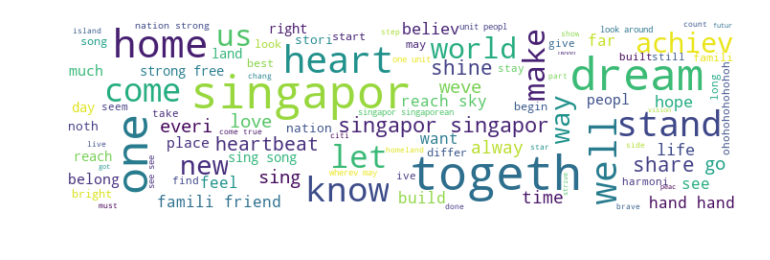

CPU times: user 733 ms, sys: 48.2 ms, total: 782 ms
Wall time: 623 ms


In [132]:
%%time

text = " ".join(e for e in data['lyrics'])

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", width=700).generate(text)
# Save image file 
wordcloud.to_file("./bag_of_words.png")

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

    

### Bag of Words

In [133]:
# lists to store the vocab and counts
vocab = []
count = []
# iterate through each vocab and count append the value to designated lists
for key, value in dictionary:
    vocab.append(key)
    count.append(value)
# store the count in panadas dataframe with vocab as index
vocab_after_stem = pd.Series(count, index=vocab)

# sort the dataframe
vocab_after_stem = vocab_after_stem.sort_values(ascending=False)

print("total vacab is", len(vocab_after_stem))


total vacab is 596


In [134]:
count = CountVectorizer()
bag_of_words = count.fit_transform(np.array(data['lyrics']))
# Show feature matrix
bag_of_words.toarray()
# Get feature names
feature_names = count.get_feature_names()
print("feature_names", len(feature_names))

bag_of_wrods_dataFrame = pd.DataFrame(bag_of_words.toarray(), columns=feature_names)

pd.concat([data.year, bag_of_wrods_dataFrame], axis=1, sort=False)


feature_names 504


,year,achiev,across,add,afar,afraid,ago,ahead,air,alight,...,yeah,year,yearn,yet,yo,you,youll,young,your,youv
0,1984,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,2
1,1986,8,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1987,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1990,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1998,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1999,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
6,2000,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7,2001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,2002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,2003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## The most used word in total lyrics

In [135]:
mostly_used_word = bag_of_wrods_dataFrame.sum(axis=0).sort_values(ascending=False)
mostly_used_word_dataFrame = pd.DataFrame(data=mostly_used_word, columns=["count"])
mostly_used_word_dataFrame.head(20)

,count
singapor,98
togeth,66
one,58
dream,52
home,50
heart,34
well,33
know,33
come,32
stand,31


## Pick top words in bag of words




In [136]:
# Singapore, Together, One, Dream, Home
pd.concat([data.year, bag_of_wrods_dataFrame.singapor, bag_of_wrods_dataFrame.togeth, bag_of_wrods_dataFrame.dream, bag_of_wrods_dataFrame.home], axis=1, sort=False)

,year,singapor,togeth,dream,home
0,1984,7,1,0,1
1,1986,9,3,1,0
2,1987,10,3,0,0
3,1990,4,0,0,0
4,1998,2,1,2,6
5,1999,3,5,2,0
6,2000,0,0,1,1
7,2001,0,1,1,1
8,2002,0,4,0,0
9,2003,10,8,0,0


## Song Lyrics Similiarity
### TF-IDF Extraction

## Lyrics Similiarity

In [137]:
# create the object of tfid vectorizer
tfid_vectorizer = TfidfVectorizer(analyzer='word', min_df = 0, stop_words = 'english')
# fit the vectorizer using the text data
tfid_vectorizer.fit(data['lyrics'])
# collect the vocabulary items used in the vectorizer
dictionary = tfid_vectorizer.vocabulary_.items()  

# extract the tfid representation matrix of the text data
tfid_matrix = tfid_vectorizer.transform(data['lyrics'])
# collect the tfid matrix in numpy array
array = tfid_matrix.todense()

# store the tf-idf array into pandas dataframe
similiarity_df = pd.DataFrame(array, columns=tfid_vectorizer.get_feature_names())

pd.concat([data.year, similiarity_df], axis=1, sort=False)


,year,achiev,add,afar,afraid,ago,ahead,air,alight,aliv,...,worri,worthwhil,write,yeah,year,yearn,yo,youll,young,youv
0,1984,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.13294,0.000000,0.000000,0.000000,0.000000,0.000000,0.107363,0.000000,0.26588
1,1986,0.511749,0.000000,0.00000,0.000000,0.000000,0.000000,0.103979,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2,1987,0.075723,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
3,1990,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
4,1998,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
5,1999,0.088700,0.000000,0.00000,0.127953,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.116440,0.000000,0.000000,0.000000,0.000000,0.00000
6,2000,0.000000,0.000000,0.12307,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.109219,0.00000
7,2001,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
8,2002,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
9,2003,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


Use Scikit learn Cosine Similarity function to compare the first document i.e. Document 0 with the other Documents in Corpus. 

Find songs with similar with Because it's Singapore


In [138]:
song_number = 24
current_song = tfid_matrix[song_number-1:song_number]
similarity = cosine_similarity(tfid_matrix[song_number-1:song_number].toarray(), tfid_matrix.toarray())

print("Song: ", data['title'][song_number-1])

# sort the dataframe
similarity_dataFrame = pd.DataFrame(data=similarity.flatten(), columns=["cosine_similarity"])
similarity_dataFrame['title'] = data['title']
similarity_dataFrame['year'] = data['year']

similarity_dataFrame.sort_values(by=['cosine_similarity'], ascending=False)


Song:  Because it's Singapore


,cosine_similarity,title,year
23,1.000000,Because it's Singapore,2017
24,0.297777,We are Singapore remix,2018
25,0.281339,Our Singapore - remix of We Will Get There (20...,2019
2,0.278583,We are Singapore,1987
8,0.275578,We Will Get There,2002
9,0.274681,One United People,2003
5,0.266684,Together,1999
21,0.263443,Our Singapore,2015
20,0.251536,One Singapore,2013
3,0.251397,"One People, One Nation, One Singapore",1990


## Using TSNE to Plot a Subset of Similar Words from Word2Vec


In [139]:
current_directory = os.getcwd()
final_directory = os.path.join(current_directory, r'word2vec')
if not os.path.exists(final_directory):
   os.makedirs(final_directory)


In [140]:
import gensim
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence
from gensim import corpora, models
from gensim.models import LdaMulticore
from gensim.models import Word2Vec
from gensim.corpora import Dictionary, MmCorpus


data = pd.read_csv("./songs.csv")

all_sentences_normalized_filepath = 'word2vec/all_lyrics_text.txt'

with open(all_sentences_normalized_filepath) as foo:
    lines = len(foo.readlines())
    print("total lines: ", lines)



total lines:  821


In [141]:
with open(all_sentences_normalized_filepath, 'w', encoding='utf-8') as f:
    c = len(data.lyrics.values)
    for lyrics in data.lyrics.values:
        if pd.isnull(lyrics): # if there is null, go to next
            continue
        f.write(formatted_text(lyrics) + '\n')


In [142]:
%%time
USE_PREMADE_BIGRAM_MODEL = False
all_bigram_model_filepath = 'word2vec/all_bigram_model'

all_unigram_sentences = LineSentence(all_sentences_normalized_filepath)
if not USE_PREMADE_BIGRAM_MODEL:    
    
    all_bigram_model = Phrases(all_unigram_sentences) #check whether phrase or not
    all_bigram_model.save(all_bigram_model_filepath)
    
else:
    all_bigram_model = Phrases.load(all_bigram_model_filepath)


CPU times: user 12.9 ms, sys: 1.37 ms, total: 14.3 ms
Wall time: 13.4 ms


In [143]:
print(all_sentences_normalized_filepath)

word2vec/all_lyrics_text.txt


In [144]:
%%time

USE_PREMADE_BIGRAM_SENTENCES = False

all_bigram_sentences_filepath = 'word2vec/all_sentences_for_word2vec.txt'

if not USE_PREMADE_BIGRAM_SENTENCES:
    
    with open(all_bigram_sentences_filepath, 'w', encoding='utf-8') as f:
        for unigram_sentence in all_unigram_sentences:
            all_bigram_sentence = all_bigram_model[unigram_sentence]
            f.write(' '.join(all_bigram_sentence) + '\n')
else:
    assert path.exists(all_bigram_sentences_filepath)


CPU times: user 22.3 ms, sys: 1.78 ms, total: 24.1 ms
Wall time: 22.8 ms


In [145]:
%%time

USE_PREMADE_WORD2VEC = False

all2vec_filepath = 'word2vec/all_word2vec_model'

if not USE_PREMADE_WORD2VEC:
    lyrics_for_word2vec = LineSentence(all_bigram_sentences_filepath)
    all2vec = Word2Vec(lyrics_for_word2vec, size=100, window=5, min_count=1, sg=1)
    for _ in range(25):
        all2vec.train(lyrics_for_word2vec, total_examples=675, epochs=30)
    all2vec.save(all2vec_filepath)
else:
    all2vec = Word2Vec.load(all2vec_filepath)
all2vec.init_sims()


CPU times: user 7.92 s, sys: 330 ms, total: 8.25 s
Wall time: 8.1 s


In [146]:
all2vec_filepath = 'word2vec/all_word2vec_model'
all2vec = Word2Vec.load(all2vec_filepath)

In [147]:
wv_dataFrame = pd.DataFrame(all2vec.wv.index2word)
wv_dataFrame.head()

,0
0,the
1,we
2,and
3,a
4,to


## Find the most smiliar words with 'singapore'  


In [148]:
all2vec.wv.most_similar(positive=['singapore'], topn=20)


[('singaporeans', 0.4886384904384613),
 ('can_achieve', 0.47636678814888),
 ('forevermore', 0.47428518533706665),
 ('taken', 0.46544092893600464),
 ('lies', 0.4637361764907837),
 ('granted', 0.45269906520843506),
 ('stand_up', 0.45057278871536255),
 ('thankful', 0.4459690451622009),
 ('hands', 0.44596001505851746),
 ('sometimes', 0.44463759660720825),
 ('smile', 0.44153642654418945),
 ('ohohohohohohoh', 0.43680906295776367),
 ('goal', 0.4352743327617645),
 ('winding', 0.4331600069999695),
 ('best', 0.41725143790245056),
 ('homeland', 0.41246941685676575),
 ('heartbeat', 0.39498093724250793),
 ('more', 0.3875159025192261),
 ('things', 0.3851689100265503),
 ('united_people', 0.3823704421520233)]

In [149]:
all2vec_dic = dict({})
for idx, key in enumerate(all2vec.wv.vocab):
    all2vec_dic[key] = all2vec.wv[key].tolist()
    
all2vec_dataFrame = pd.DataFrame.from_dict(all2vec_dic).T
all2vec_dataFrame.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
stand_up,0.257417,0.209166,0.244219,0.262244,-0.805063,0.281853,-0.605714,-0.094620,-0.187395,-0.098706,...,0.042647,-0.424864,-0.268660,0.608685,0.866828,0.685142,-0.779812,0.100402,-0.776636,-0.778945
for,0.307494,0.115045,-0.323993,-0.139529,-0.978145,0.426805,-0.557581,0.021925,-0.174210,-0.213276,...,-0.018837,0.163642,0.078272,0.134470,-0.179654,1.033848,-0.275707,0.337783,-0.751039,-0.298114
singapore,0.143893,-0.172946,0.440202,0.156252,-1.170935,0.348060,-0.437944,0.134201,0.072109,0.388073,...,-0.241387,-0.113901,0.124120,0.715689,0.474089,0.770865,-0.491704,0.072265,-0.724320,0.055396
do,0.720961,-0.188956,0.744806,0.180814,-0.183259,0.209979,-0.025045,-0.240287,0.029131,-0.796657,...,-0.408800,-0.343047,-0.266774,-0.000963,0.521091,0.738457,-0.966446,-0.112870,-0.808486,-1.032681
the,-0.156952,0.005320,0.251161,0.345678,-0.348032,-0.342436,0.109295,0.135434,-0.013026,-0.086318,...,0.606690,-0.328394,-0.531886,0.578989,-0.615049,-0.133333,-0.336000,0.377492,-0.482865,0.500100


In [150]:
%%time

from sklearn.manifold import TSNE
import pickle

USE_PREMADE_TSNE = False

tsne_filepath = 'example/tsne.pkl'

if not USE_PREMADE_TSNE:
    
    tsne = TSNE(random_state=0)
    tsne_points = tsne.fit_transform(all2vec_dataFrame)
    with open(tsne_filepath, 'wb') as f:
        pickle.dump(tsne_points, f)
else:
    with open(tsne_filepath, 'rb') as f:
        tsne_points = pickle.load(f)

tsne_df = pd.DataFrame(tsne_points, index=all2vec_dataFrame.index, columns=['x_coord', 'y_coord'])
tsne_df['word'] = tsne_df.index



CPU times: user 3.85 s, sys: 23.5 ms, total: 3.87 s
Wall time: 3.86 s


In [151]:
tsne_df.head()

,x_coord,y_coord,word
stand_up,-9.788138,-27.684673,stand_up
for,-14.755581,-12.862411,for
singapore,5.336820,-11.703509,singapore
do,-11.582910,-26.829905,do
the,-14.491520,-10.379032,the


In [111]:
from bokeh.plotting import figure, show, output_notebook

from bokeh.models import HoverTool, ColumnDataSource, LabelSet, value


# prepare the data in a form suitable for bokeh.
plot_data = ColumnDataSource(data=tsne_df)

# create the plot and configure it
tsne_plot = figure(title='t-SNE Word Embeddings',
                   plot_width = 800,
                   plot_height = 800,
                   active_scroll='wheel_zoom'
                  )

tsne_plot.circle('x_coord', 'y_coord', source=plot_data,
                 color='red', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color='orange')

labels = LabelSet(x='x_coord', y='y_coord', text='word', level='glyph',
              x_offset=5, y_offset=5, source=plot_data, render_mode='canvas')


# adjust visual elements of the plot
tsne_plot.title.text_font_size = value('16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None

tsne_plot.add_layout(labels)

# show time
output_notebook()
show(tsne_plot);

Loading BokehJS ...